In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import xarray as xr

GROUP A — Prepare Temporal Features

In [108]:
monitor_df =  pd.read_csv("results/monitoring_anomaly_scores.csv")
monitor_df

,time,y,x,NDVI,NBR,BSI,B11,B12,spatial_ref,anomaly_score
0,2023-01-08,21.192449,81.153305,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
1,2023-01-08,21.192449,81.153394,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
2,2023-01-08,21.192449,81.153484,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
3,2023-01-08,21.192449,81.153573,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
4,2023-01-08,21.192449,81.153662,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
...,...,...,...,...,...,...,...,...,...,...
195277,2024-12-28,21.198826,81.157685,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
195278,2024-12-28,21.198826,81.157774,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
195279,2024-12-28,21.198826,81.157864,0.0,0.0,0.0,65535.0,65535.0,0,0.000069
195280,2024-12-28,21.198826,81.157953,0.0,0.0,0.0,65535.0,65535.0,0,0.000069


In [109]:
monitor_df["time"] = pd.to_datetime(monitor_df["time"])


In [110]:
# sort the data 

monitor_df = monitor_df.sort_values(["y", "x", "time"])

# NDVI fetaures per pixel 
monitor_df["NDVI_prev"] = monitor_df.groupby(["y","x"])["NDVI"].shift(1)
monitor_df["delta_NDVI"] = monitor_df["NDVI"] - monitor_df["NDVI_prev"]



In [111]:
# Compute NDVI slope (rolling window)
WINDOW = 3  # temporal window (can tune)

def rolling_slope(series):
    x = np.arange(len(series))
    if len(series) < 2:
        return np.nan
    return np.polyfit(x, series, 1)[0]

monitor_df["NDVI_slope"] = (
    monitor_df
    .groupby(["y","x"])["NDVI"]
    .rolling(WINDOW, min_periods=2)
    .apply(rolling_slope, raw=False)
    .reset_index(level=[0,1], drop=True)
)


GROUP B — Define Adaptive Thresholds

In [112]:
# Anomaly threshold (per mine, data-driven)

ANOMALY_THRESH = monitor_df["anomaly_score"].quantile(0.90)

# NDVI drop condition
#NDVI_DROP_THRESH = -0.02   # small, conservative drop


In [113]:
# Adaptive NDVI drop: per-pixel 10th percentile of historical delta_NDVI (significant drop for that pixel)
monitor_df["NDVI_DROP_THRESH"] = monitor_df.groupby(["y", "x"])["delta_NDVI"].transform(lambda x: x.quantile(0.10) if len(x) > 1 else np.nan)

In [114]:
# Adaptive persistence: based on median time delta in days
monitor_df["time"] = pd.to_datetime(monitor_df["time"])  # Ensure time is datetime
time_deltas = monitor_df.groupby(["y", "x"])["time"].diff().dt.days.dropna()
median_delta_days = time_deltas.median() if not time_deltas.empty else 10  # Fallback to 10 days if no data
K_PERSIST = max(2, round(30 / median_delta_days))  # ~30 days persistence, min 2

GROUP C — Initial State Assignment (Per Time)

In [115]:
monitor_df["state_raw"] = 0  # Normal

# Candidate transition
transition_mask = (
    (monitor_df["anomaly_score"] > ANOMALY_THRESH) &
    (monitor_df["delta_NDVI"] < monitor_df["NDVI_DROP_THRESH"])
)

monitor_df.loc[transition_mask, "state_raw"] = 1


GROUP D — Persistence Logic (THE KEY PART)

In [116]:
#K_PERSIST = 4  # persistence length (tuneable)


In [117]:
monitor_df["state"] = 0  # final state

def apply_persistence(group):
    states = group["state_raw"].values
    final = np.zeros_like(states)

    count = 0
    for i in range(len(states)):
        if states[i] == 1:
            count += 1
            if count >= K_PERSIST:
                final[i] = 2  # Excavated
            else:
                final[i] = 1  # Transition
        else:
            count = 0
            final[i] = 0
    return pd.Series(final, index=group.index)


In [118]:
monitor_df["state"] = (
    monitor_df
    .groupby(["y","x"], group_keys=False)
    .apply(apply_persistence)
)


/tmp/ipykernel_14732/4264610111.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_persistence)


In [119]:
assert len(monitor_df["state"]) == len(monitor_df)
assert monitor_df["state"].isna().sum() == 0
print(monitor_df["state"].value_counts())


state
0    189842
1      5410
2        30
Name: count, dtype: int64


GROUP E — Binary Excavation Mask

In [120]:
# final per-pixel excavation decision

monitor_df["excavated"] = (monitor_df["state"] == 2).astype(int)


GROUP F — Convert StateMap to Raster (Per Date)

In [121]:
state_maps = {}
excavation_maps = {}

for t in monitor_df["time"].unique():
    df_t = monitor_df[monitor_df["time"] == t]

    state_maps[t] = (
        df_t.set_index(["y","x"])["state"].to_xarray()
    )

    excavation_maps[t] = (
        df_t.set_index(["y","x"])["excavated"].to_xarray()
    )


GROUP G — Visual Sanity Checks

In [122]:
import geopandas as gpd

mine = gpd.read_file("content/mines/mines_cils.shp")

In [123]:
sample_date = sorted(state_maps.keys())[40]

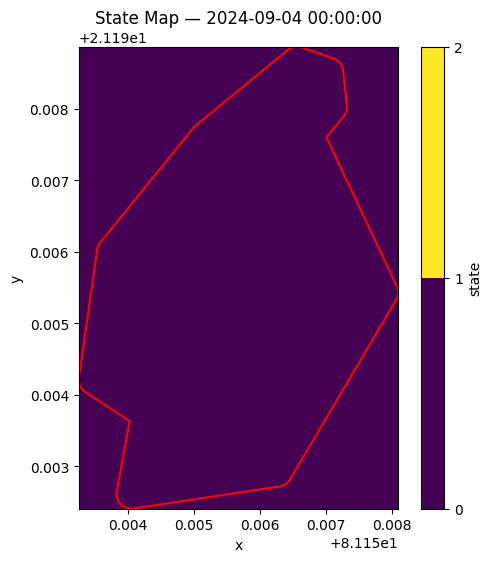

In [124]:
# 01 state map

plt.figure(figsize=(6,6))
state_maps[sample_date].plot(
    cmap="viridis",
    levels=[0,1,2]
)
mine.boundary.plot(ax=plt.gca(), color="red")
plt.title(f"State Map — {sample_date}")
plt.show()


/tmp/ipykernel_14732/1045236456.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


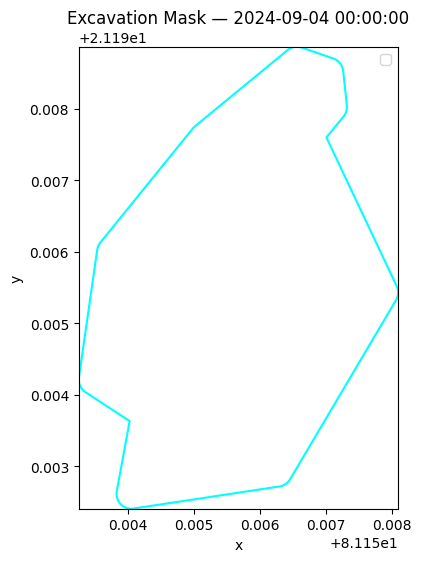

In [125]:
# 02 Excavation mask

plt.figure(figsize=(6,6))
excavation_maps[sample_date].where(excavation_maps[sample_date] == 1).plot(cmap="Reds", add_colorbar=False)
mine.boundary.plot(ax=plt.gca(), color="cyan")
plt.title(f"Excavation Mask — {sample_date}")
plt.legend()
plt.show()

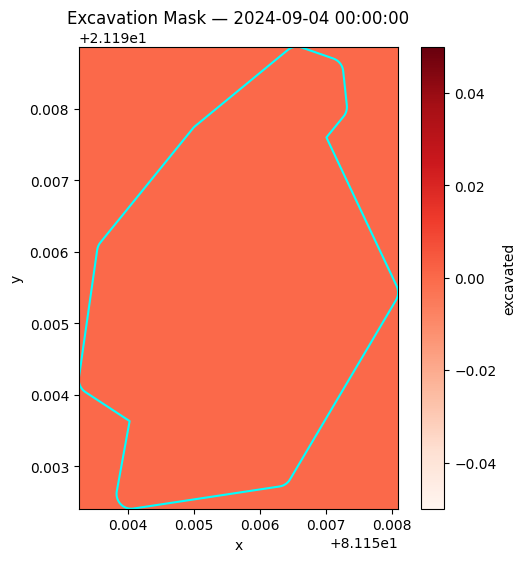

In [126]:
# 02 Excavation mask

plt.figure(figsize=(6,6))
excavation_maps[sample_date].plot(cmap="Reds")
mine.boundary.plot(ax=plt.gca(), color="cyan")

plt.title(f"Excavation Mask — {sample_date}")
plt.show()


In [127]:
sample_date = sorted(state_maps.keys())[22]

In [128]:
import rasterio.features
import rioxarray
import xarray as xr


transform = excavation_maps[sample_date].rio.transform()

mine_mask = rasterio.features.rasterize(
    [(mine.geometry.iloc[0], 1)],
    out_shape=excavation_maps[sample_date].shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

mine_mask = xr.DataArray(
    mine_mask,
    coords=excavation_maps[sample_date].coords,
    dims=excavation_maps[sample_date].dims
)


In [129]:
masked_excavation = excavation_maps[sample_date].where(mine_mask == 1)


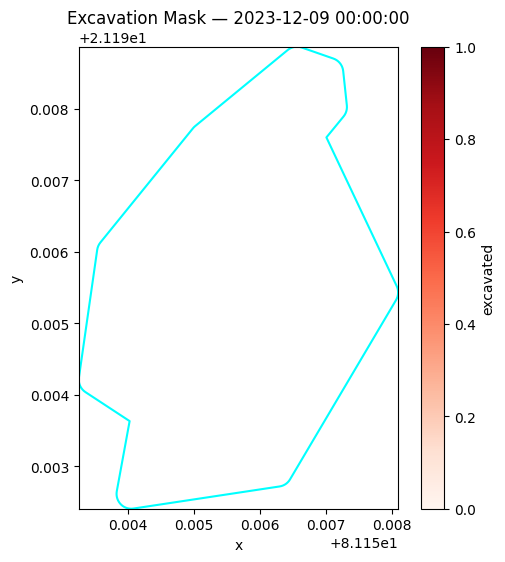

In [130]:
plt.figure(figsize=(6,6))
masked_excavation.plot(
    cmap="Reds",
    vmin=0,
    vmax=1
)
mine.boundary.plot(ax=plt.gca(), color="cyan")
plt.title(f"Excavation Mask — {sample_date}")
plt.show()


In [131]:
VEG_NDVI_THRESH = 0.35  # tune per region
monitor_df["veg_like"] = monitor_df["NDVI"] > VEG_NDVI_THRESH


In [132]:
def apply_persistence_with_recovery(group):
    states = group["state_raw"].values
    ndvi = group["NDVI"].values

    final = np.zeros(len(group), dtype=np.int8)

    count = 0
    excavated = False

    for i in range(len(states)):
        if states[i] == 1:
            count += 1
            if count >= K_PERSIST and not excavated:
                final[i] = 2
                excavated = True
            else:
                final[i] = 1
        else:
            count = 0
            final[i] = 0

        # NDVI recovery cancels excavation
        if excavated and ndvi[i] > VEG_NDVI_THRESH:
            excavated = False
            final[i] = 0

    # 🔑 RETURN SERIES WITH ORIGINAL INDEX
    return pd.Series(final, index=group.index)


In [133]:
monitor_df["state"] = (
    monitor_df
    .groupby(["y","x"], group_keys=False)
    .apply(apply_persistence_with_recovery)
)


/tmp/ipykernel_14732/275470453.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_persistence_with_recovery)


In [134]:
assert len(monitor_df["state"]) == len(monitor_df)
assert monitor_df["state"].isna().sum() == 0
print(monitor_df["state"].value_counts())


state
0    189842
1      5410
2        30
Name: count, dtype: int64


In [135]:
state_maps = {}
excavation_maps = {}

for t in monitor_df["time"].unique():
    df_t = monitor_df[monitor_df["time"] == t]

    state_maps[t] = (
        df_t.set_index(["y","x"])["state"].to_xarray()
    )

    excavation_maps[t] = (
        df_t.set_index(["y","x"])["excavated"].to_xarray()
    )


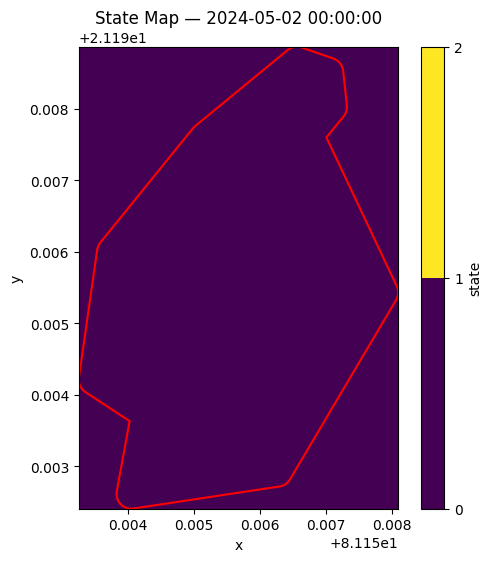

In [136]:
# 01 state map

sample_date = sorted(state_maps.keys())[32]

plt.figure(figsize=(6,6))
state_maps[sample_date].plot(
    cmap="viridis",
    levels=[0,1,2]
)
mine.boundary.plot(ax=plt.gca(), color="red")
plt.title(f"State Map — {sample_date}")
plt.show()
